# Stage 3: Calculate Metrics and Analyze Results

This notebook:
1. Loads ground truth data and fetched results
2. Calculates accuracy metrics (F1, Precision, Recall) for keys, non-keys, and overall
3. Analyzes performance by strategy
4. Visualizes trade-offs between accuracy, efficiency, and quality
5. Examines performance across different table characteristics

## Setup and Imports

In [99]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from unidecode import unidecode
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
plt.rcParams['figure.figsize'] = (12, 7)

In [100]:
# Configuration
ROOT = Path('.')
PROCESSING_ROOT = ROOT / 'processing'
BENCHMARK_ROOT = ROOT / 'benchmark_tables'
DATA_DIR = PROCESSING_ROOT / '0_data'
FETCHING_DIR = PROCESSING_ROOT / '2_fetching'
OUTPUT_DIR = PROCESSING_ROOT / '3_metrics'

# Find latest directories
data_subdirs = sorted([d for d in DATA_DIR.iterdir() if d.is_dir()], reverse=True)
fetching_subdirs = sorted([d for d in FETCHING_DIR.iterdir() if d.is_dir()], reverse=True)

if not data_subdirs:
    raise FileNotFoundError(f"No data found in {DATA_DIR}")
if not fetching_subdirs:
    raise FileNotFoundError(f"No fetching results found in {FETCHING_DIR}")

LATEST_DATA_DIR = data_subdirs[0]
LATEST_FETCHING_DIR = fetching_subdirs[0]

print(f'Data directory: {LATEST_DATA_DIR}')
LATEST_FETCHING_DIR = Path('processing/2_fetching/20251016_001443')
print(f'Fetching directory: {LATEST_FETCHING_DIR}')

# Create output directory
from datetime import datetime
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
output_dir = OUTPUT_DIR / timestamp
output_dir.mkdir(parents=True, exist_ok=True)
print(f'Output directory: {output_dir}')

Data directory: processing/0_data/20251004_213355
Fetching directory: processing/2_fetching/20251016_001443
Output directory: processing/3_metrics/20251016_011011


## Accuracy Evaluation Functions

These functions are adapted from `X101_Calculate_Metrics.ipynb` to evaluate table accuracy.

In [101]:
def normalize_value(value, is_date=False):
    """Normalize a cell value for comparison."""
    if value != value:  # NaN check
        return ''

    if is_date:
        try:
            return pd.to_datetime(value)
        except:
            pass
        
    if type(value).__module__ == 'numpy':
        value = value.item()

    if isinstance(value, str):
        # Handle numeric strings
        if value.startswith('-') and value.replace('-', '').replace(',', '').isdigit():
            return int(value.replace(',', ''))
        if value.replace(',', '').isdigit():
            return int(value.replace(',', ''))
        if value.startswith('=') and value[1:].isdigit():
            return int(value.replace('=', ''))
        if value.startswith('-') and value.replace('-', '').replace(',', '').replace('.', '').isdigit():
            return float(value.replace(',', ''))
        if value.replace(',', '').replace('.', '').isdigit():
            return float(value.replace(',', ''))
        
        value = value.strip().lower()

        if value in ('none', 'n/a', 'nan', '-'):
            return ''

        value = value.replace('&', 'and')

        if value == 'united states':
            return 'usa'
        if value == 'united kingdom':
            return 'uk'
        
        value = unidecode(value)
        value = ''.join(c for c in value if c.isalnum())
        return value

    return value


def normalize_key(value, is_date=False):
    """Normalize a key column value for matching."""
    if value != value:  # NaN check
        return ''

    if is_date:
        try:
            return str(pd.to_datetime(value))
        except:
            pass

    if isinstance(value, str):
        value = value.strip().lower()

        if value in ('none', 'n/a', 'nan', '-', '--', 'unknown'):
            return ''

        value = value.replace('&', 'and')

        if value == 'united states':
            return 'usa'
        if value == 'united kingdom':
            return 'uk'

        value = unidecode(value)
        value = ''.join(c for c in value if c.isalnum())
        return value

    return str(value)


def normalize_primary_columns(df, norm_columns, date_columns, primary_columns, keys_type):
    """Normalize primary key columns and return list of key tuples."""
    df = df.copy()
    
    for col in norm_columns:
        df[col] = df[col].apply(lambda x: normalize_key(x, col in date_columns))
    
    for col, key_type in zip(primary_columns, keys_type):
        if key_type == 'year':
            df[col] = df[col].astype(float).astype(int)
        df[col] = df[col].astype(str)
    
    return [tuple(r) for r in df[primary_columns].to_numpy()]


def find_row(df, columns, values):
    """Find a row in dataframe by key column values."""
    query = ' & '.join([f'(`{col}`=="{value}")' for col, value in zip(columns, values)])
    return df.query(query)


def evaluate_table(df_fetched, df_ref, primary_columns, keys_type, date_columns, epsilons):
    """
    Evaluate fetched table against reference table.
    
    Returns tuple of:
    - keys_recall, keys_precision, keys_f1_score
    - non_keys_recall, non_keys_precision, non_keys_f1_score
    - recall, precision, f1_score
    - relative_non_key_accuracy
    """
    columns = df_ref.columns
    
    # Ensure fetched table has same columns as reference
    df_fetched = df_fetched[columns].copy()
    df_ref = df_ref.copy()
    df_fetched = df_fetched.drop_duplicates(subset=primary_columns)
    
    # Remove rows with missing primary keys
    for pc in primary_columns:
        df_fetched = df_fetched[df_fetched[pc].notna()]
    
    # Normalize primary key columns IN THE DATAFRAMES
    # This modifies the dataframes so find_row() can work correctly
    norm_columns = set(primary_columns)
    
    for col in norm_columns:
        df_fetched[col] = df_fetched[col].apply(lambda x: normalize_key(x, col in date_columns))
        df_ref[col] = df_ref[col].apply(lambda x: normalize_key(x, col in date_columns))
    
    for col, key_type in zip(primary_columns, keys_type):
        if key_type == 'year':
            df_fetched[col] = df_fetched[col].astype(float).astype(int)
            df_ref[col] = df_ref[col].astype(float).astype(int)
        df_fetched[col] = df_fetched[col].astype(str)
        df_ref[col] = df_ref[col].astype(str)
    
    # Extract entities for matching
    fetched_entities = [tuple(r) for r in df_fetched[primary_columns].to_numpy()]
    ref_entities = [tuple(r) for r in df_ref[primary_columns].to_numpy()]
    
    total_matches = 0
    key_matches = 0
    
    for fetched_entity in fetched_entities:
        if fetched_entity in ref_entities:
            row_fetched = find_row(df_fetched, primary_columns, fetched_entity)
            row_ref = find_row(df_ref, primary_columns, fetched_entity)
            key_matches += 1
            
            for column in columns:
                try:
                    value_fetched = row_fetched[column].values[0]
                    value_ref = row_ref[column].values[0]
                    
                    norm_value_fetched = normalize_value(value_fetched, column in date_columns)
                    norm_value_ref = normalize_value(value_ref, column in date_columns)
                    
                    # Check for exact match first
                    if norm_value_fetched == norm_value_ref:
                        total_matches += 1
                    # For epsilon columns, try numeric comparison with tolerance
                    elif column in epsilons and norm_value_ref != '' and norm_value_fetched != '':
                        try:
                            # Convert both to float for numeric comparison
                            fv = float(norm_value_fetched)
                            rv = float(norm_value_ref)
                            # Allow 0.1% tolerance
                            if abs(fv - rv) <= abs(rv * 0.001):
                                total_matches += 1
                        except (ValueError, TypeError):
                            # If conversion fails, they don't match
                            pass
                except Exception as e:
                    # Silently skip errors in individual cell comparisons
                    pass
    
    # Calculate overall metrics
    recall = total_matches / (df_ref.shape[0] * df_ref.shape[1]) if df_ref.shape[0] > 0 else 0.0
    precision = total_matches / (df_fetched.shape[0] * df_fetched.shape[1]) if df_fetched.shape[0] > 0 else 0.0
    f1_score = 2 * recall * precision / (recall + precision) if (recall + precision) > 0 else 0.0
    
    # Calculate key metrics
    keys_recall = key_matches / len(ref_entities) if len(ref_entities) > 0 else 0.0
    keys_precision = key_matches / len(fetched_entities) if len(fetched_entities) > 0 else 0.0
    keys_f1_score = 2 * keys_recall * keys_precision / (keys_recall + keys_precision) if (keys_recall + keys_precision) > 0 else 0.0
    
    # Calculate non-key metrics
    nk = len(primary_columns)
    non_keys_recall = (total_matches - key_matches * nk) / (df_ref.shape[0] * (df_ref.shape[1] - nk)) if df_ref.shape[0] > 0 and df_ref.shape[1] > nk else 0.0
    non_keys_precision = (total_matches - key_matches * nk) / (df_fetched.shape[0] * (df_fetched.shape[1] - nk)) if df_fetched.shape[0] > 0 and df_fetched.shape[1] > nk else 0.0
    non_keys_f1_score = 2 * non_keys_recall * non_keys_precision / (non_keys_recall + non_keys_precision) if (non_keys_recall + non_keys_precision) > 0 else 0.0
    
    relative_non_key_accuracy = (total_matches - key_matches * nk) / (key_matches * (df_ref.shape[1] - nk)) if key_matches > 0 and df_ref.shape[1] > nk else 0.0
    
    return (keys_recall, keys_precision, keys_f1_score,
            non_keys_recall, non_keys_precision, non_keys_f1_score,
            recall, precision, f1_score,
            relative_non_key_accuracy)


## Load Data and Calculate Accuracy Metrics

In [102]:
# Load metadata for all tables
metadata = {}
for json_file in LATEST_DATA_DIR.glob('*.json'):
    table_id = json_file.stem
    with open(json_file, 'r', encoding='utf-8') as f:
        data = json.load(f)
        # Extract metadata from 'meta' key
        metadata[table_id] = data['meta'] if 'meta' in data else data

print(f'Loaded metadata for {len(metadata)} tables')

Loaded metadata for 48 tables


In [103]:
# Evaluate accuracy for all strategy-table combinations
import traceback

results = []

strategies = ['range_based_alphabetic', 'range_based_semantic', 'range_based_unrestricted']

for strategy in strategies:
    strategy_dir = LATEST_FETCHING_DIR / strategy
    if not strategy_dir.exists():
        continue
    
    csv_files = list(strategy_dir.glob('*.csv'))
    print(f"\n{'='*70}")
    print(f"Evaluating {strategy.upper()}: {len(csv_files)} tables")
    print(f"{'='*70}")
    
    for csv_file in csv_files:
        table_id = csv_file.stem
        
        if table_id not in metadata:
            print(f"  ⚠ Skipping {table_id}: metadata not found")
            continue
        
        md = metadata[table_id]
        
        try:
            # Load fetched and ground truth tables
            df_fetched = pd.read_csv(csv_file)
            df_ref = pd.read_csv(LATEST_DATA_DIR / f"{table_id}.csv")
            
            # Load execution metadata
            json_file = strategy_dir / f"{table_id}.json"
            with open(json_file, 'r', encoding='utf-8') as f:
                data = json.load(f)
                exec_meta = data['execution_metadata']
                pages = data.get('pages', [])
            
            # Extract metadata
            primary_columns = md['keys']
            keys_type = md['keys_type']
            date_columns = md.get('dateColumns', [])
            epsilons = md.get('epsilons', [])
            
            # Calculate accuracy
            kr, kp, kf1, nkr, nkp, nkf1, r, p, f1, rnka = evaluate_table(
                df_fetched, df_ref, primary_columns, keys_type, date_columns, epsilons
            )
            
            # Calculate page size metrics
            page_sizes = [p.get('rows_returned', 0) for p in pages]
            if page_sizes:
                page_size_variance = np.var(page_sizes)
                size_counts = Counter(page_sizes)
                total_pages = len(page_sizes)
                probs = [count / total_pages for count in size_counts.values()]
                entropy = -sum(p * np.log2(p) for p in probs if p > 0)
                num_unique = len(size_counts)
                page_size_normalized_entropy = entropy / np.log2(num_unique) if num_unique > 1 else 0
            else:
                page_size_variance = 0
                page_size_normalized_entropy = 0
            
            # Combine with execution metrics
            result = {
                'table_id': table_id,
                'table_name': md['name'],
                'strategy': strategy,
                'num_rows': md['numDataRows'],
                'num_cols': md['numCols'],
                'num_cells': md['numCells'],
                
                # Accuracy metrics
                'keys_recall': kr,
                'keys_precision': kp,
                'keys_f1': kf1,
                'non_keys_recall': nkr,
                'non_keys_precision': nkp,
                'non_keys_f1': nkf1,
                'recall': r,
                'precision': p,
                'f1_score': f1,
                'relative_non_key_accuracy': rnka,
                
                # Performance metrics
                'total_pages': exec_meta['total_pages'],
                'total_tokens': exec_meta['total_tokens'],
                'total_latency': exec_meta['total_latency'],
                'avg_latency': exec_meta['avg_latency'],
                'error_rate': exec_meta['error_rate'],
                'duplicate_rows': exec_meta['duplicate_rows'],
                'columns_consistent': exec_meta['columns_consistent'],
                
                # Efficiency metrics
                'tokens_per_row': exec_meta['total_tokens'] / exec_meta['total_rows_fetched'] if exec_meta['total_rows_fetched'] > 0 else 0,
                'latency_per_row': exec_meta['total_latency'] / exec_meta['total_rows_fetched'] if exec_meta['total_rows_fetched'] > 0 else 0,
                'rows_fetched': exec_meta['total_rows_fetched'],
                
                # Page size distribution metrics
                'page_size_variance': page_size_variance,
                'page_size_normalized_entropy': page_size_normalized_entropy
            }
            
            results.append(result)
            print(f"  ✓ {table_id}: F1={f1:.4f}, Keys_F1={kf1:.4f}, Tokens={exec_meta['total_tokens']}")
            
        except Exception as e:
            print(f"  ✗ {table_id}: Error - {e}")
            print(f"     {traceback.format_exc()}")
            continue

# Create results dataframe
df_results = pd.DataFrame(results)
print(f"\n{'='*70}")
print(f"Evaluated {len(df_results)} strategy-table combinations")
print(f"{'='*70}")


Evaluating RANGE_BASED_ALPHABETIC: 20 tables
  ✓ 39_uk_demographics_1960_2012: F1=0.1187, Keys_F1=0.5479, Tokens=8846
  ✓ 42_jack_nicklaus_achievements_1962_2005: F1=0.3929, Keys_F1=0.6032, Tokens=5663
  ✓ 19_living_proof_the_farewell_tour: F1=0.3939, Keys_F1=0.4098, Tokens=9632
  ✓ 22_usa_demographics_1935_2010: F1=0.2372, Keys_F1=0.5385, Tokens=7153
  ✓ 35_guitar_hero_5_songs: F1=0.5013, Keys_F1=0.6299, Tokens=4517
  ✓ 32_fa_cup_qualifying_rounds_1999_2000: F1=0.2721, Keys_F1=0.3603, Tokens=7173
  ✓ 36_south_cambridgeshire_district_council_1973_2012: F1=0.6382, Keys_F1=0.8235, Tokens=7722
  ✓ 12_rock_band_downloadable_2011: F1=0.1841, Keys_F1=0.2185, Tokens=3537
  ✓ 16_curling_teams_women_2013_2014: F1=0.3875, Keys_F1=0.4735, Tokens=7773
  ✓ 41_new_zealand_football_results_1922_2012: F1=0.0964, Keys_F1=0.6000, Tokens=3279
  ✓ 28_equestrian_2012: F1=0.4675, Keys_F1=0.6545, Tokens=5330
  ✓ 51_just_dance_kids_2_tracks: F1=0.3136, Keys_F1=0.8293, Tokens=7043
  ✓ 2_belgium_demographics_1

In [104]:
# Save detailed results
results_file = output_dir / 'detailed_results.csv'
df_results.to_csv(results_file, index=False)
print(f'Saved detailed results to {results_file}')

# Display summary statistics
print(f"\nDataFrame shape: {df_results.shape}")
print(f"Columns: {list(df_results.columns)}")
if len(df_results) > 0:
    print(f"Strategies found: {df_results['strategy'].unique()}")
    df_results.head()
else:
    print("⚠ DataFrame is empty!")

Saved detailed results to processing/3_metrics/20251016_011011/detailed_results.csv

DataFrame shape: (58, 28)
Columns: ['table_id', 'table_name', 'strategy', 'num_rows', 'num_cols', 'num_cells', 'keys_recall', 'keys_precision', 'keys_f1', 'non_keys_recall', 'non_keys_precision', 'non_keys_f1', 'recall', 'precision', 'f1_score', 'relative_non_key_accuracy', 'total_pages', 'total_tokens', 'total_latency', 'avg_latency', 'error_rate', 'duplicate_rows', 'columns_consistent', 'tokens_per_row', 'latency_per_row', 'rows_fetched', 'page_size_variance', 'page_size_normalized_entropy']
Strategies found: ['range_based_alphabetic' 'range_based_semantic'
 'range_based_unrestricted']


# Page Size Distribution Analysis

Analyze the variance and normalized entropy of page sizes (cardinality) across strategies.

Page Size Variance and Normalized Entropy Analysis
Total strategy-table combinations with page data: 58

Page Size Metrics by Strategy:
                         page_size_variance                               \
                                       mean       std     min        max   
strategy                                                                   
range_based_alphabetic             124.0625  196.2211  0.0000   660.2500   
range_based_semantic               336.5473  475.9472  0.4898  1844.6875   
range_based_unrestricted           209.7099  601.5266  0.1875  2623.2500   

                         page_size_normalized_entropy                       
                                                 mean     std     min  max  
strategy                                                                    
range_based_alphabetic                         0.8152  0.2889  0.0000  1.0  
range_based_semantic                           0.9433  0.0778  0.7150  1.0  
range_based_unrestrict

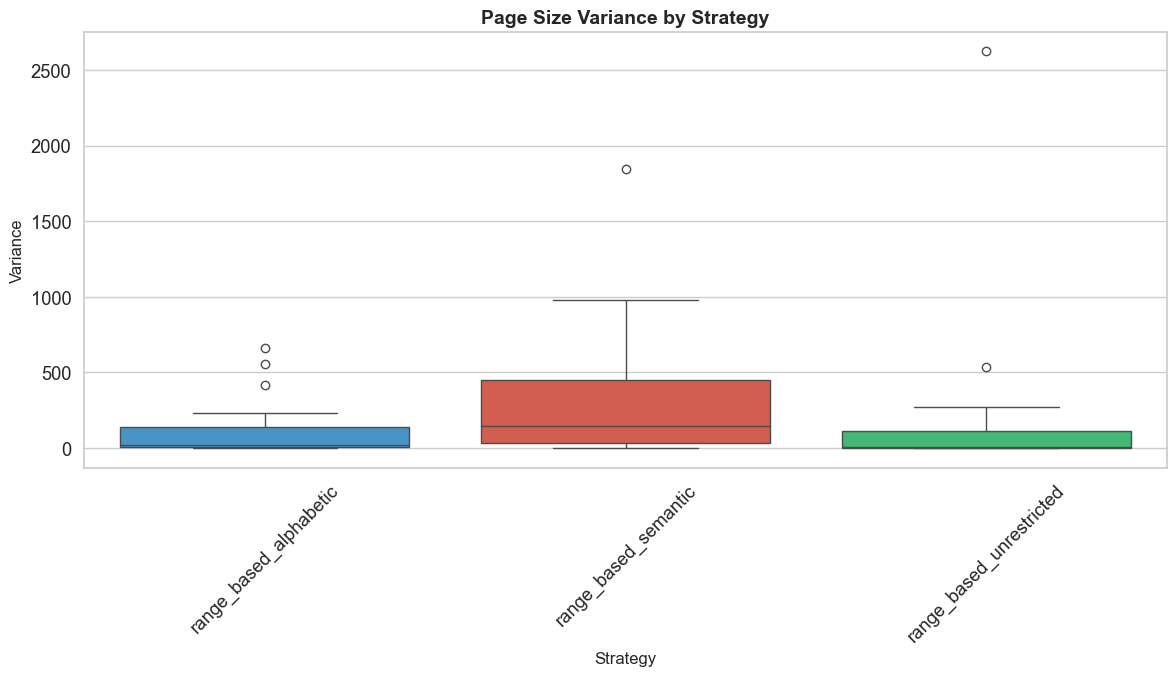

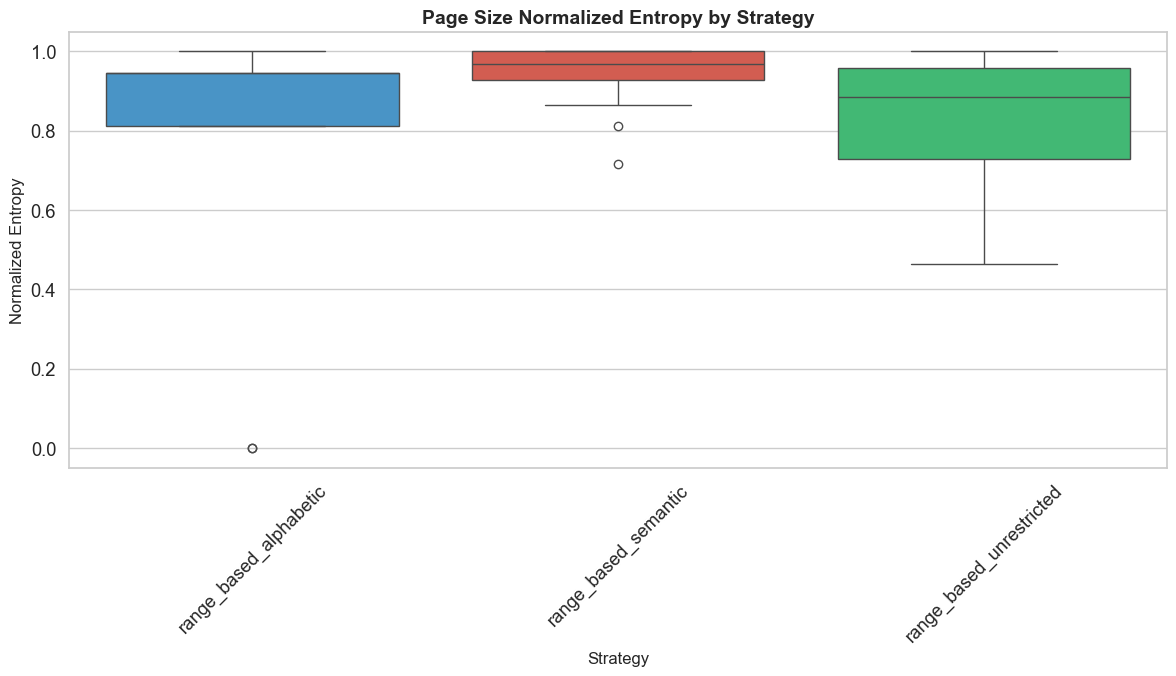


Visualizations saved to:
  processing/3_metrics/20251016_011011/page_size_variance.png
  processing/3_metrics/20251016_011011/page_size_entropy.png


In [105]:
# Analyze page size metrics
print("Page Size Variance and Normalized Entropy Analysis")
print("="*60)

# Summary statistics
page_metrics = df_results[['strategy', 'page_size_variance', 'page_size_normalized_entropy']].copy()
page_metrics = page_metrics.dropna()

print(f"Total strategy-table combinations with page data: {len(page_metrics)}")

# Group by strategy
strategy_page_stats = page_metrics.groupby('strategy').agg({
    'page_size_variance': ['mean', 'std', 'min', 'max'],
    'page_size_normalized_entropy': ['mean', 'std', 'min', 'max']
}).round(4)

print("\nPage Size Metrics by Strategy:")
print(strategy_page_stats)

# Visualization - Page Size Variance
plt.figure(figsize=(12, 7))
colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#9b59b6']
sns.boxplot(data=page_metrics, x='strategy', y='page_size_variance', palette=colors)
plt.title('Page Size Variance by Strategy', fontsize=14, fontweight='bold')
plt.xlabel('Strategy', fontsize=12)
plt.ylabel('Variance', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(output_dir / 'page_size_variance.png', dpi=300, bbox_inches='tight')
plt.show()

# Visualization - Page Size Normalized Entropy
plt.figure(figsize=(12, 7))
sns.boxplot(data=page_metrics, x='strategy', y='page_size_normalized_entropy', palette=colors)
plt.title('Page Size Normalized Entropy by Strategy', fontsize=14, fontweight='bold')
plt.xlabel('Strategy', fontsize=12)
plt.ylabel('Normalized Entropy', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(output_dir / 'page_size_entropy.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nVisualizations saved to:")
print(f"  {output_dir / 'page_size_variance.png'}")
print(f"  {output_dir / 'page_size_entropy.png'}")

## Summary Statistics by Strategy

In [106]:
# Calculate summary statistics per strategy
if len(df_results) == 0:
    print("⚠ No results to summarize!")
else:
    summary_cols = ['f1_score', 'keys_f1', 'non_keys_f1', 'total_tokens', 'total_latency', 
                    'error_rate', 'duplicate_rows', 'tokens_per_row', 'latency_per_row']

    summary_stats = df_results.groupby('strategy')[summary_cols].agg(['mean', 'std', 'min', 'max'])
    summary_stats = summary_stats.round(4)

    # Save summary
    summary_file = output_dir / 'strategy_summary.csv'
    summary_stats.to_csv(summary_file)
    print(f'Saved strategy summary to {summary_file}')

    display(summary_stats)

Saved strategy summary to processing/3_metrics/20251016_011011/strategy_summary.csv


f1_score                         keys_f1          \
                             mean     std     min     max    mean     std   
strategy                                                                    
range_based_alphabetic     0.2847  0.1667  0.0385  0.6382  0.4871  0.2258   
range_based_semantic       0.3385  0.2101  0.0000  0.7147  0.5565  0.2895   
range_based_unrestricted   0.4282  0.2602  0.0000  0.8097  0.6599  0.3513   

                                         non_keys_f1          ...  \
                             min     max        mean     std  ...   
strategy                                                      ...   
range_based_alphabetic    0.0577  0.8293      0.2407  0.1762  ...   
range_based_semantic      0.0000  0.9633      0.2913  0.2301  ...   
range_based_unrestricted  0.0000  1.0000      0.3751  0.2670  ...   

                         duplicate_rows      tokens_per_row                    \
                                    min  max           mean      std      min   
strategy                                                                        
range_based_alphabetic                0  168        77.3931  36.7707  28.7576   
range_based_semantic                  0  105        81.1487  42.9152  22.4545   
range_based_unrestricted              0  488        86.3559  41.9792  21.1775   

                                   latency_per_row                          
                               max            mean     std     min     max  
strategy                                                                    
range_based_alphabetic    149.0208          0.5299  0.3097  0.2208  1.5970  
range_based_semantic      166.5000          0.5994  0.3638  0.1473  1.7609  
range_based_unrestricted  177.2000          0.6794  0.4473  0.1499  2.2562  

[3 rows x 36 columns]

## Section 1: Accuracy Analysis

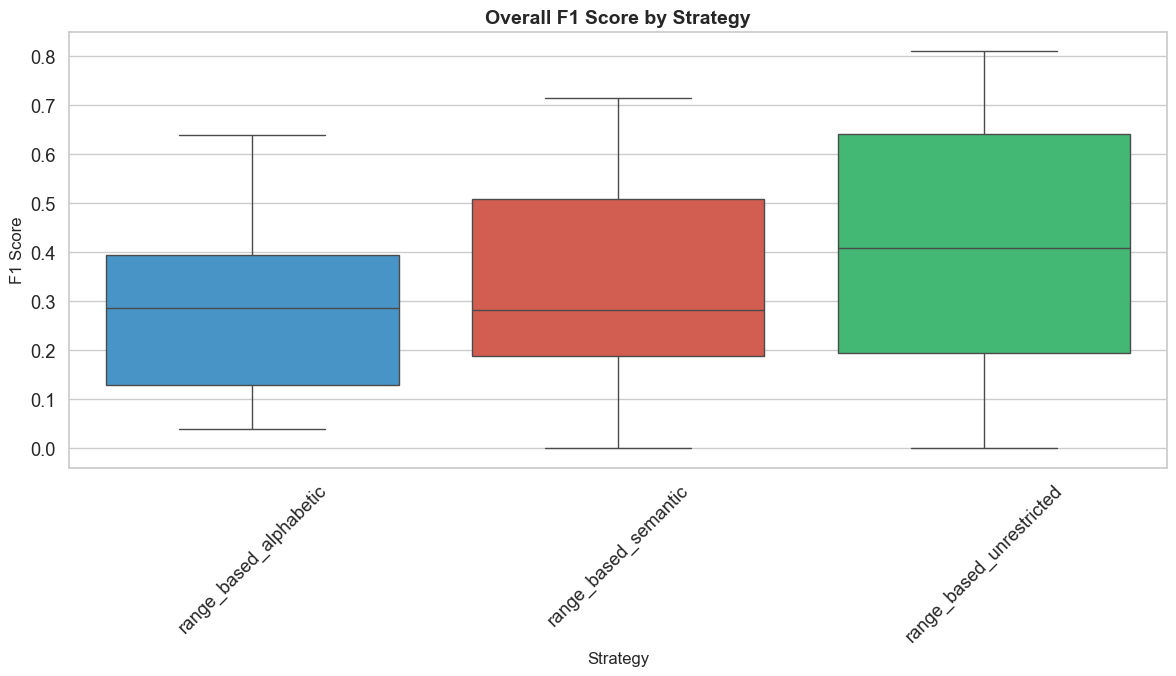

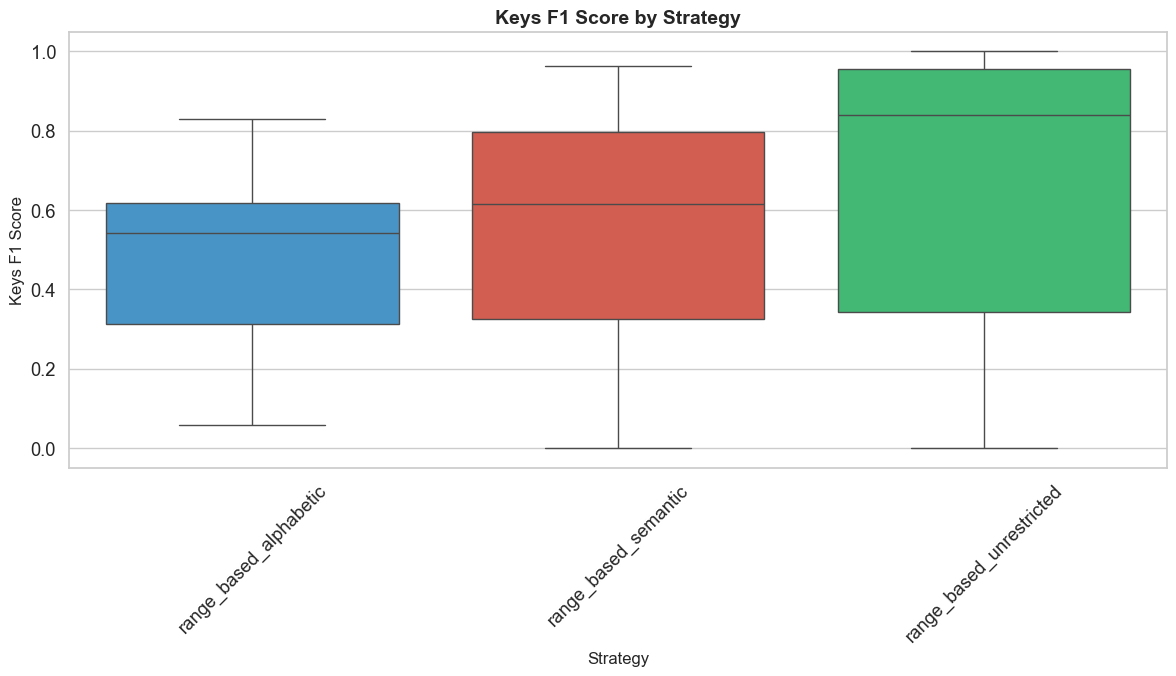

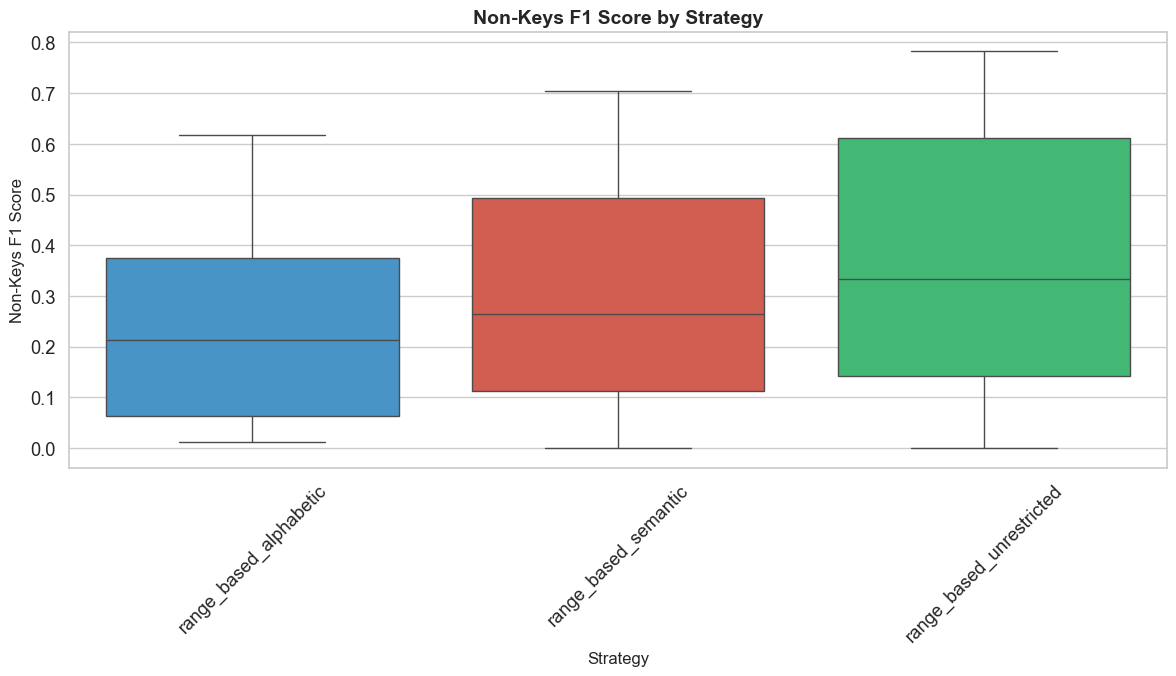

Removed 0 extreme outliers for better visualization


In [107]:
# Plot F1 Score by Strategy
if len(df_results) == 0:
    print("⚠ Cannot plot: No results available")
else:
    colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#9b59b6']
    
    # Remove extreme outliers using IQR method
    def remove_outliers(df, column, factor=3.0):
        """Remove outliers beyond factor * IQR from the quartiles"""
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - factor * IQR
        upper_bound = Q3 + factor * IQR
        return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    
    # Filter data to remove extreme outliers
    df_filtered = df_results.copy()
    df_filtered = remove_outliers(df_filtered, 'f1_score', factor=3.0)
    df_filtered = remove_outliers(df_filtered, 'keys_f1', factor=3.0)
    df_filtered = remove_outliers(df_filtered, 'non_keys_f1', factor=3.0)
    
    # Overall F1
    plt.figure(figsize=(12, 7))
    sns.boxplot(data=df_filtered, x='strategy', y='f1_score', palette=colors)
    plt.title('Overall F1 Score by Strategy', fontsize=14, fontweight='bold')
    plt.xlabel('Strategy', fontsize=12)
    plt.ylabel('F1 Score', fontsize=12)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(output_dir / 'overall_f1_by_strategy.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Keys F1
    plt.figure(figsize=(12, 7))
    sns.boxplot(data=df_filtered, x='strategy', y='keys_f1', palette=colors)
    plt.title('Keys F1 Score by Strategy', fontsize=14, fontweight='bold')
    plt.xlabel('Strategy', fontsize=12)
    plt.ylabel('Keys F1 Score', fontsize=12)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(output_dir / 'keys_f1_by_strategy.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Non-Keys F1
    plt.figure(figsize=(12, 7))
    sns.boxplot(data=df_filtered, x='strategy', y='non_keys_f1', palette=colors)
    plt.title('Non-Keys F1 Score by Strategy', fontsize=14, fontweight='bold')
    plt.xlabel('Strategy', fontsize=12)
    plt.ylabel('Non-Keys F1 Score', fontsize=12)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(output_dir / 'non_keys_f1_by_strategy.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print how many outliers were removed
    n_removed = len(df_results) - len(df_filtered)
    print(f"Removed {n_removed} extreme outliers for better visualization")

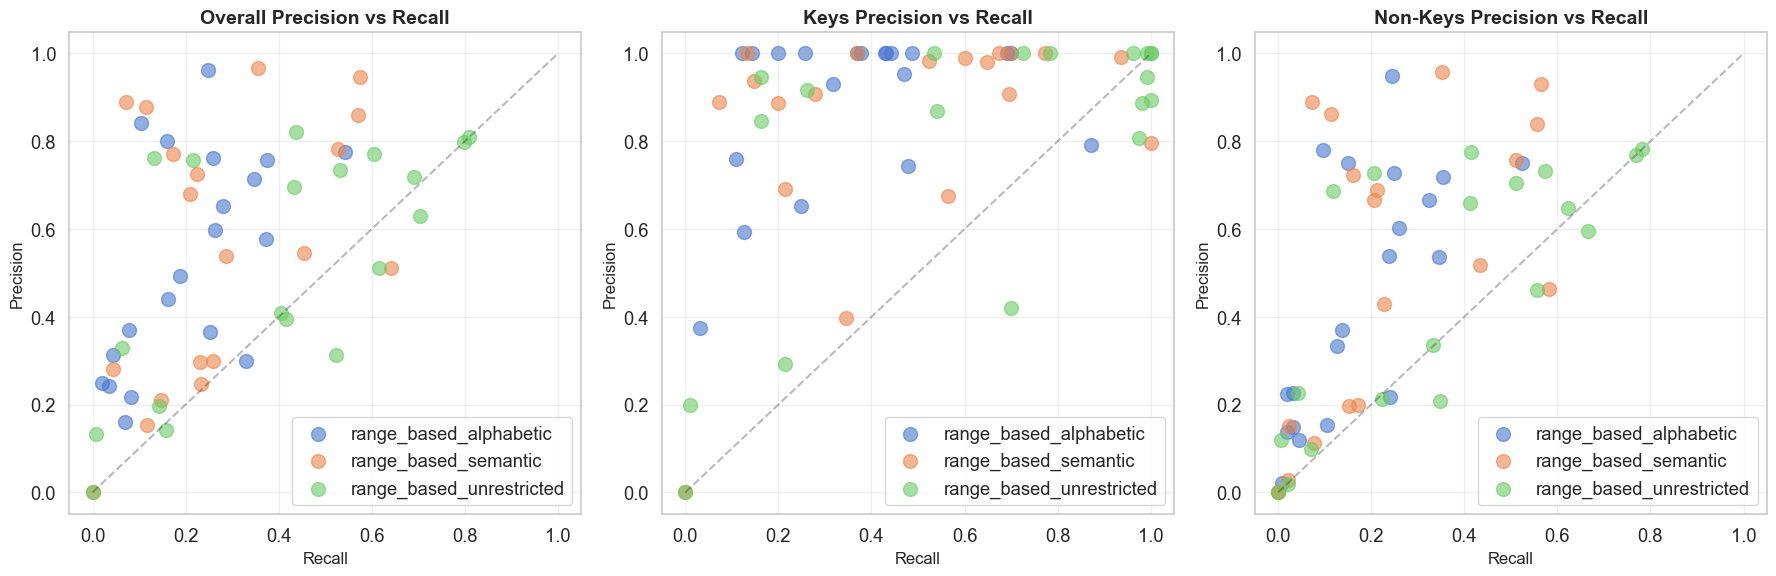

In [108]:
# Precision vs Recall by Strategy
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for idx, (metric, title) in enumerate([('Overall', 'Overall'), ('keys', 'Keys'), ('non_keys', 'Non-Keys')]):
    recall_col = f'{metric}_recall' if metric != 'Overall' else 'recall'
    precision_col = f'{metric}_precision' if metric != 'Overall' else 'precision'
    
    for strategy in df_results['strategy'].unique():
        strategy_data = df_results[df_results['strategy'] == strategy]
        axes[idx].scatter(strategy_data[recall_col], strategy_data[precision_col], 
                         label=strategy, alpha=0.6, s=100)
    
    axes[idx].set_title(f'{title} Precision vs Recall', fontsize=14, fontweight='bold')
    axes[idx].set_xlabel('Recall', fontsize=12)
    axes[idx].set_ylabel('Precision', fontsize=12)
    axes[idx].plot([0, 1], [0, 1], 'k--', alpha=0.3)
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(output_dir / 'precision_recall.png', dpi=300, bbox_inches='tight')
plt.show()

## Section 2: Performance Analysis

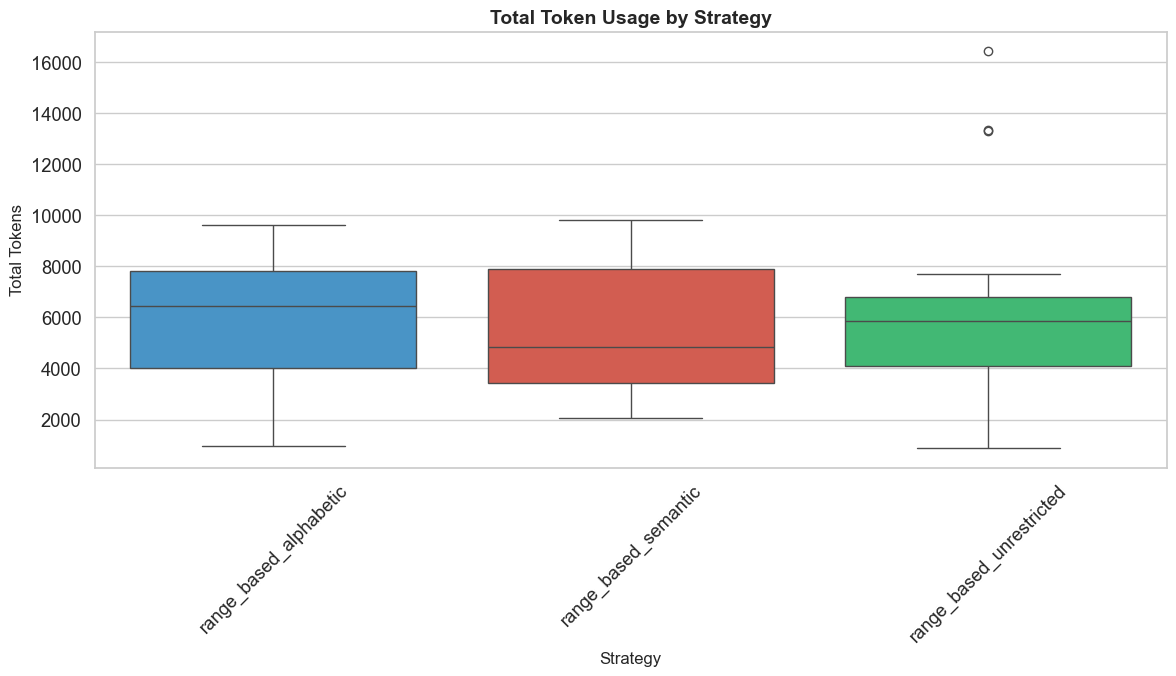

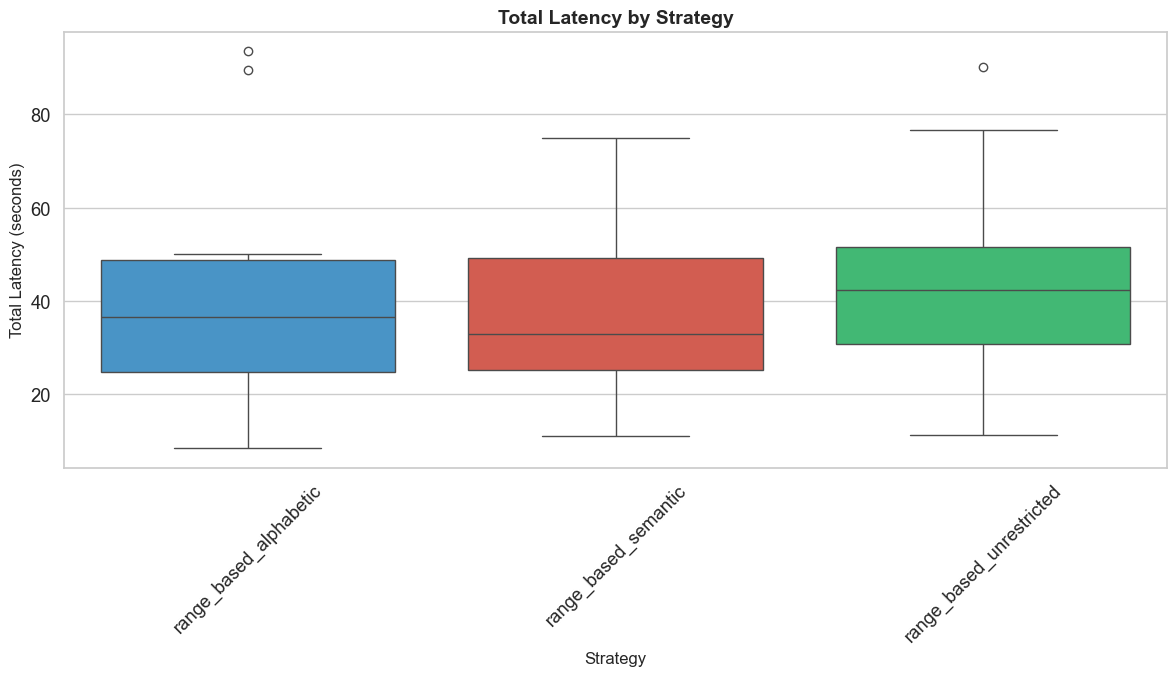

Removed 4 extreme outliers for better visualization


In [109]:
# Token Usage and Latency by Strategy
colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#9b59b6']

# Remove extreme outliers using IQR method
def remove_outliers(df, column, factor=3.0):
    """Remove outliers beyond factor * IQR from the quartiles"""
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - factor * IQR
    upper_bound = Q3 + factor * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Filter data to remove extreme outliers
df_filtered = df_results.copy()
df_filtered = remove_outliers(df_filtered, 'total_tokens', factor=3.0)
df_filtered = remove_outliers(df_filtered, 'total_latency', factor=3.0)

# Token usage
plt.figure(figsize=(12, 7))
sns.boxplot(data=df_filtered, x='strategy', y='total_tokens', palette=colors)
plt.title('Total Token Usage by Strategy', fontsize=14, fontweight='bold')
plt.xlabel('Strategy', fontsize=12)
plt.ylabel('Total Tokens', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(output_dir / 'total_tokens_by_strategy.png', dpi=300, bbox_inches='tight')
plt.show()

# Latency
plt.figure(figsize=(12, 7))
sns.boxplot(data=df_filtered, x='strategy', y='total_latency', palette=colors)
plt.title('Total Latency by Strategy', fontsize=14, fontweight='bold')
plt.xlabel('Strategy', fontsize=12)
plt.ylabel('Total Latency (seconds)', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(output_dir / 'total_latency_by_strategy.png', dpi=300, bbox_inches='tight')
plt.show()

# Print how many outliers were removed
n_removed = len(df_results) - len(df_filtered)
print(f"Removed {n_removed} extreme outliers for better visualization")

## Section 3: Efficiency Metrics

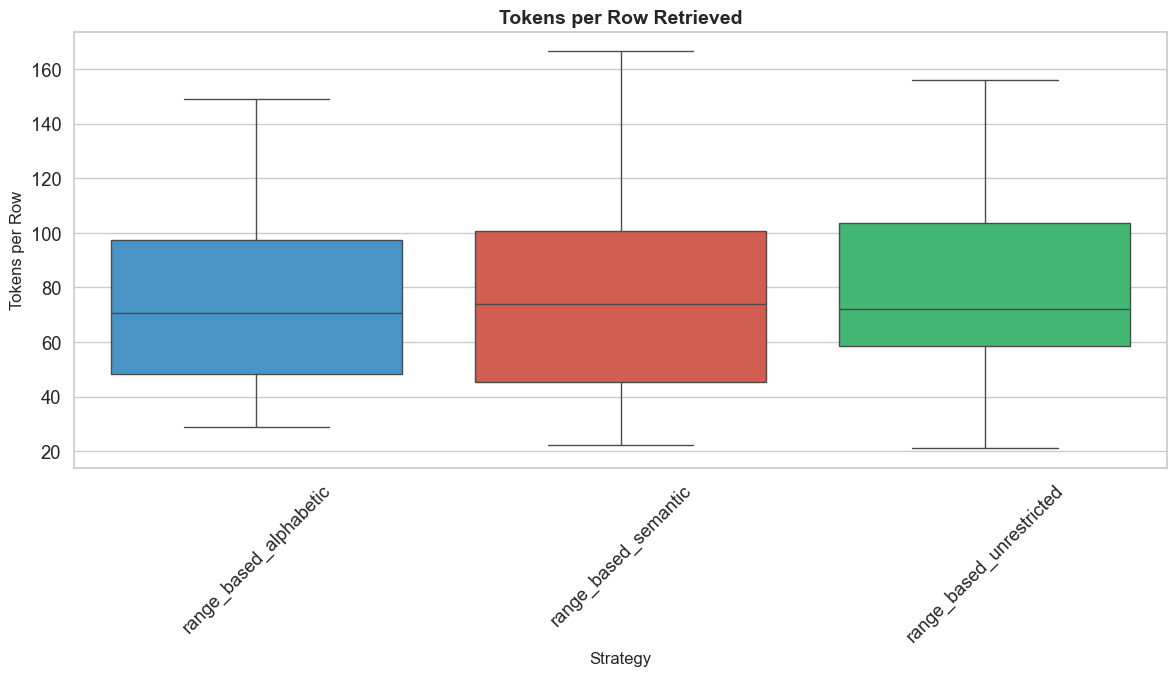

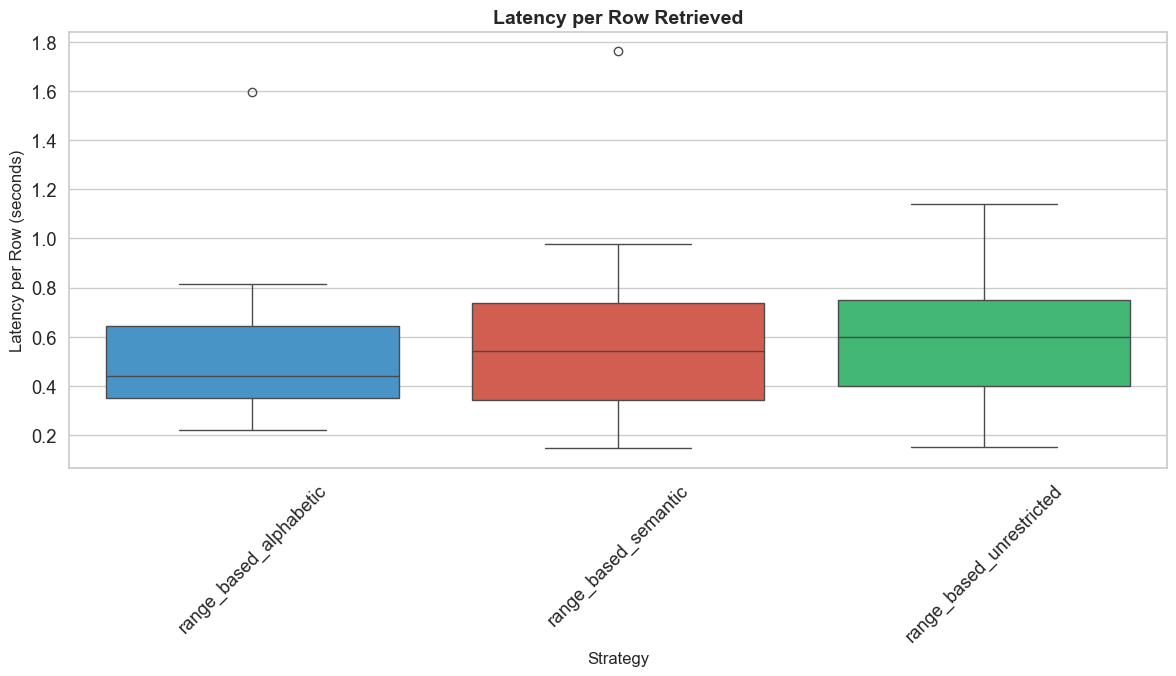

Removed 1 extreme outliers for better visualization


In [110]:
# Efficiency: Tokens and Latency per Row
colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#9b59b6']

# Remove extreme outliers using IQR method
def remove_outliers(df, column, factor=3.0):
    """Remove outliers beyond factor * IQR from the quartiles"""
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - factor * IQR
    upper_bound = Q3 + factor * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Filter data to remove extreme outliers
df_filtered = df_results.copy()
df_filtered = remove_outliers(df_filtered, 'tokens_per_row', factor=3.0)
df_filtered = remove_outliers(df_filtered, 'latency_per_row', factor=3.0)

# Tokens per row
plt.figure(figsize=(12, 7))
sns.boxplot(data=df_filtered, x='strategy', y='tokens_per_row', palette=colors)
plt.title('Tokens per Row Retrieved', fontsize=14, fontweight='bold')
plt.xlabel('Strategy', fontsize=12)
plt.ylabel('Tokens per Row', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(output_dir / 'tokens_per_row_by_strategy.png', dpi=300, bbox_inches='tight')
plt.show()

# Latency per row
plt.figure(figsize=(12, 7))
sns.boxplot(data=df_filtered, x='strategy', y='latency_per_row', palette=colors)
plt.title('Latency per Row Retrieved', fontsize=14, fontweight='bold')
plt.xlabel('Strategy', fontsize=12)
plt.ylabel('Latency per Row (seconds)', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(output_dir / 'latency_per_row_by_strategy.png', dpi=300, bbox_inches='tight')
plt.show()

# Print how many outliers were removed
n_removed = len(df_results) - len(df_filtered)
print(f"Removed {n_removed} extreme outliers for better visualization")

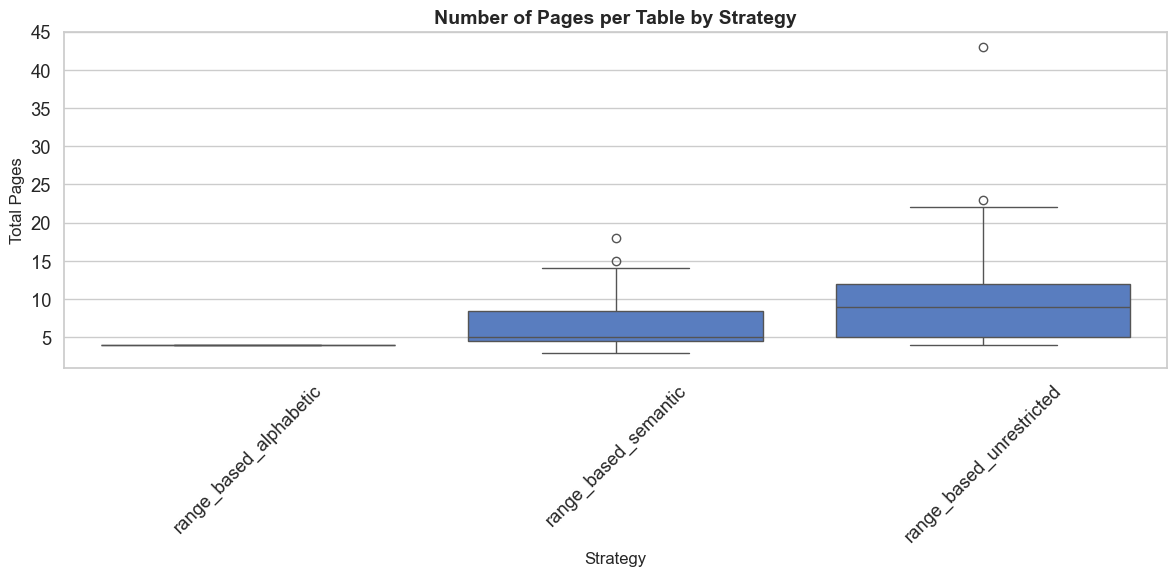

In [111]:
# Pages per Table by Strategy
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_results, x='strategy', y='total_pages')
plt.title('Number of Pages per Table by Strategy', fontsize=14, fontweight='bold')
plt.xlabel('Strategy', fontsize=12)
plt.ylabel('Total Pages', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(output_dir / 'pages_per_table.png', dpi=300, bbox_inches='tight')
plt.show()

## Section 4: Quality Metrics

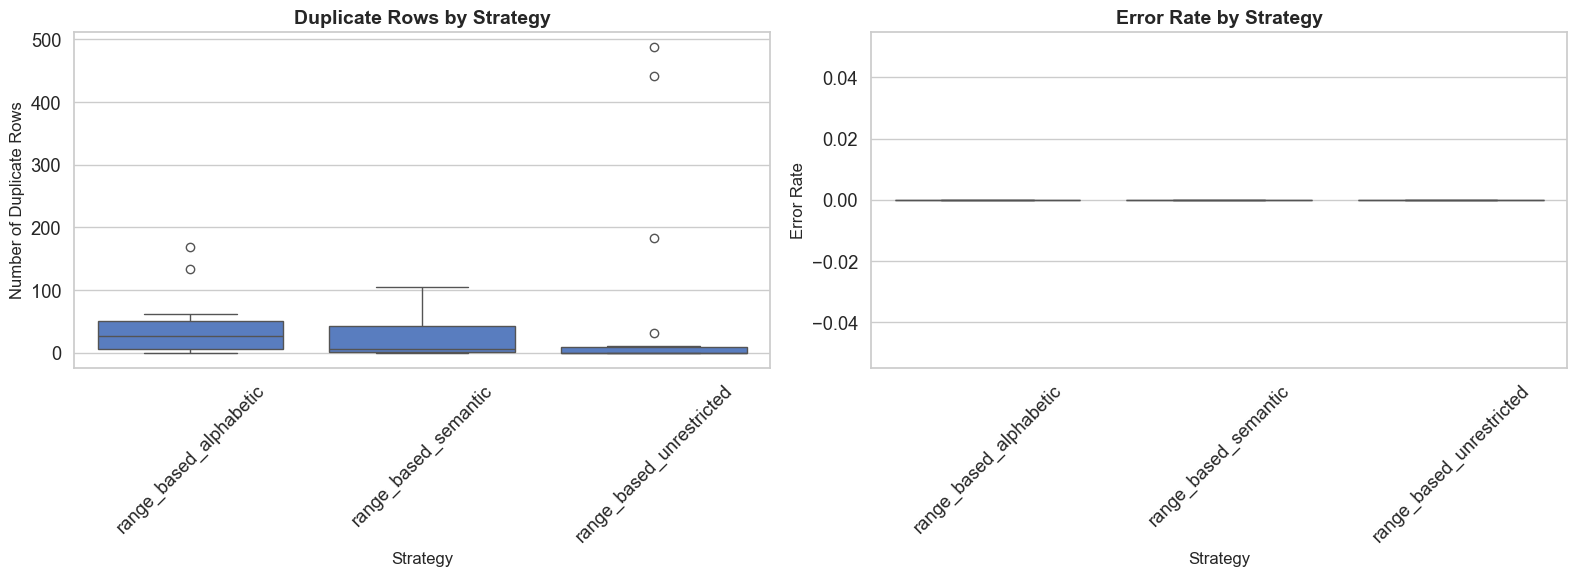

In [112]:
# Quality Metrics: Duplicates and Error Rate
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Duplicate rows
sns.boxplot(data=df_results, x='strategy', y='duplicate_rows', ax=axes[0])
axes[0].set_title('Duplicate Rows by Strategy', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Strategy', fontsize=12)
axes[0].set_ylabel('Number of Duplicate Rows', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)

# Error rate
sns.boxplot(data=df_results, x='strategy', y='error_rate', ax=axes[1])
axes[1].set_title('Error Rate by Strategy', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Strategy', fontsize=12)
axes[1].set_ylabel('Error Rate', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig(output_dir / 'quality_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

<Figure size 1200x600 with 0 Axes>

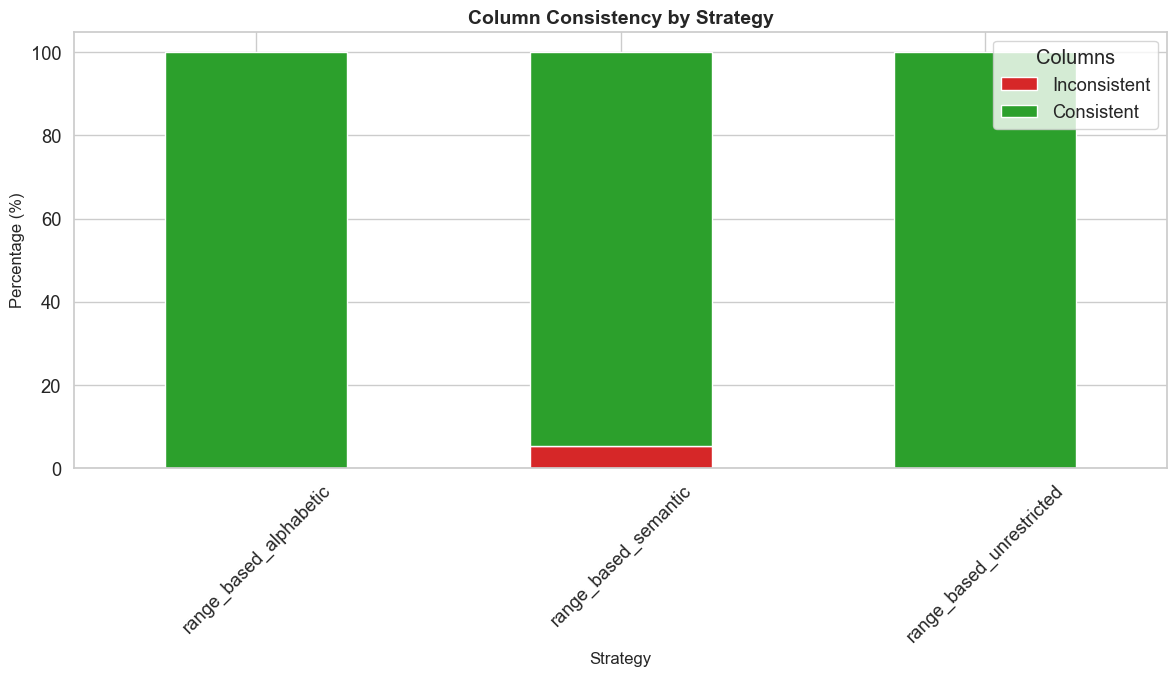

In [113]:
# Column Consistency
consistency_counts = df_results.groupby('strategy')['columns_consistent'].value_counts().unstack(fill_value=0)
consistency_pct = consistency_counts.div(consistency_counts.sum(axis=1), axis=0) * 100

plt.figure(figsize=(12, 6))
consistency_pct.plot(kind='bar', stacked=True, color=['#d62728', '#2ca02c'])
plt.title('Column Consistency by Strategy', fontsize=14, fontweight='bold')
plt.xlabel('Strategy', fontsize=12)
plt.ylabel('Percentage (%)', fontsize=12)
plt.legend(['Inconsistent', 'Consistent'], title='Columns')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(output_dir / 'column_consistency.png', dpi=300, bbox_inches='tight')
plt.show()

## Section 5: Trade-off Analysis

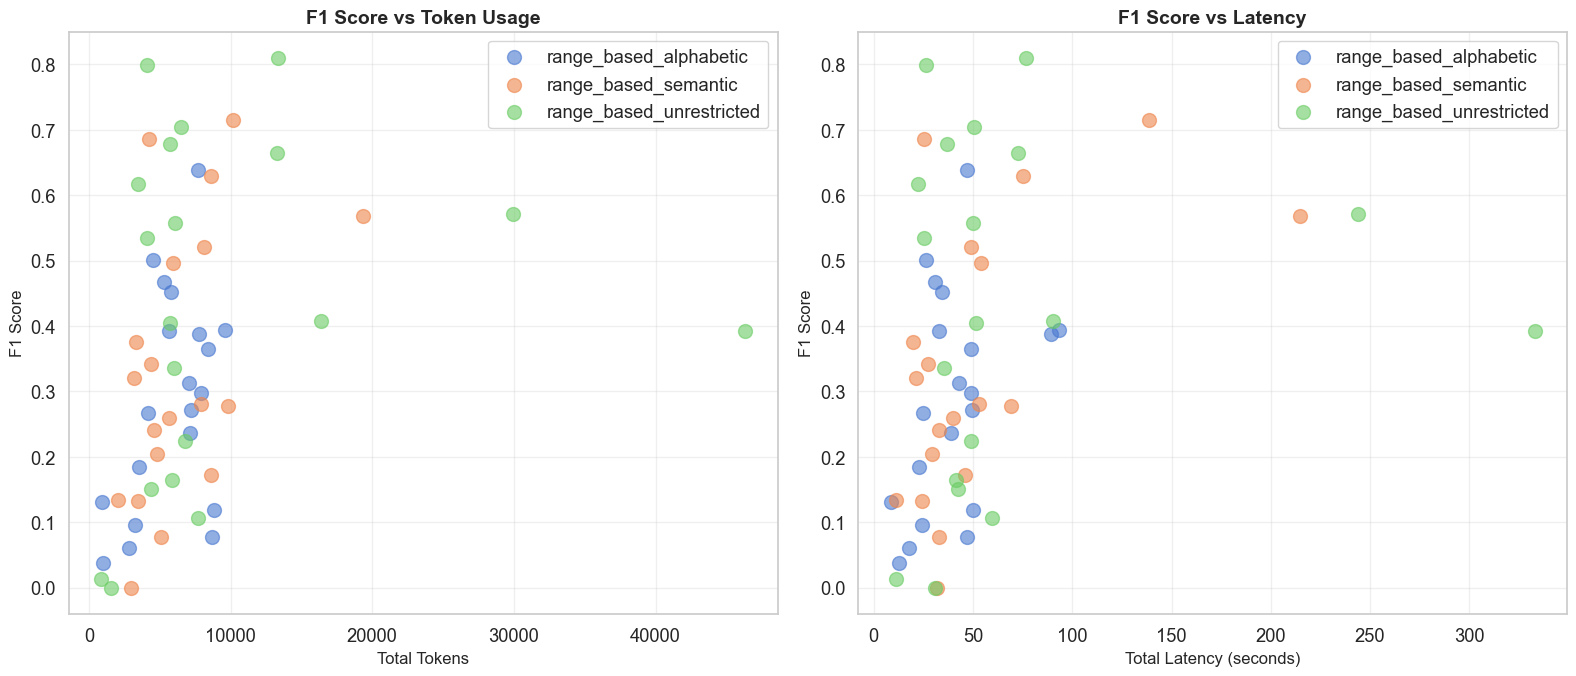

In [114]:
# F1 Score vs Token Usage
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# F1 vs Tokens
for strategy in df_results['strategy'].unique():
    strategy_data = df_results[df_results['strategy'] == strategy]
    axes[0].scatter(strategy_data['total_tokens'], strategy_data['f1_score'], 
                   label=strategy, alpha=0.6, s=100)

axes[0].set_title('F1 Score vs Token Usage', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Total Tokens', fontsize=12)
axes[0].set_ylabel('F1 Score', fontsize=12)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# F1 vs Latency
for strategy in df_results['strategy'].unique():
    strategy_data = df_results[df_results['strategy'] == strategy]
    axes[1].scatter(strategy_data['total_latency'], strategy_data['f1_score'], 
                   label=strategy, alpha=0.6, s=100)

axes[1].set_title('F1 Score vs Latency', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Total Latency (seconds)', fontsize=12)
axes[1].set_ylabel('F1 Score', fontsize=12)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(output_dir / 'tradeoff_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

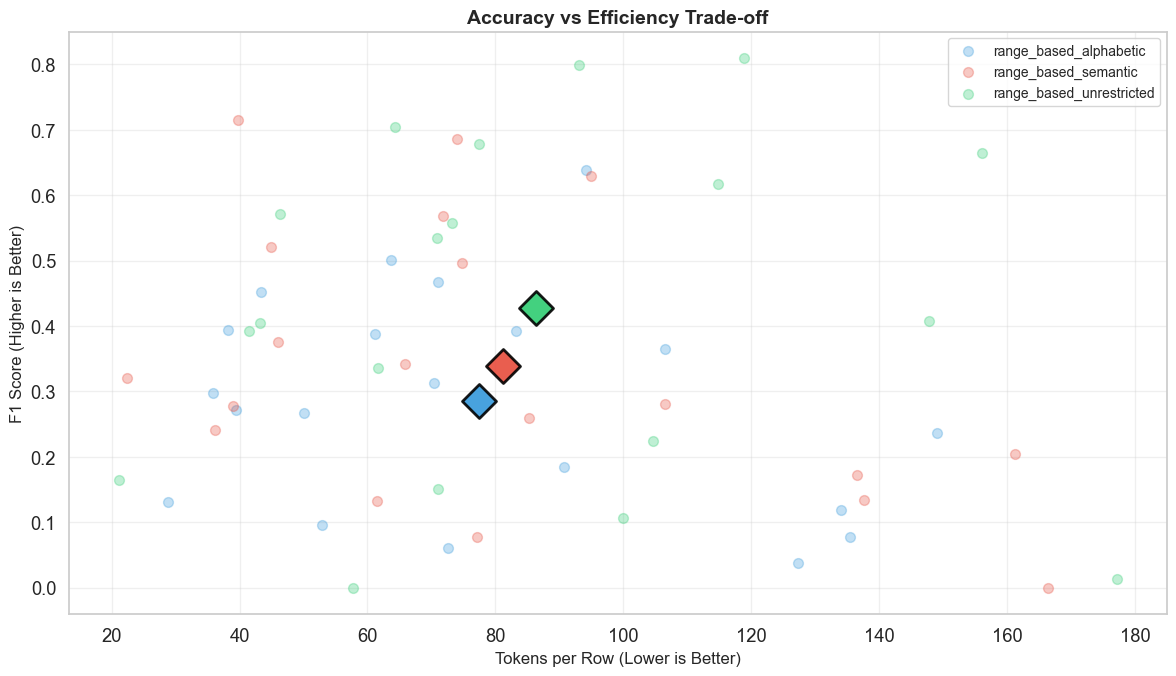

In [115]:
# Pareto Frontier: F1 vs Efficiency (Tokens per Row)
colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#9b59b6']

plt.figure(figsize=(12, 7))

# Plot individual points with lower opacity
for idx, strategy in enumerate(df_results['strategy'].unique()):
    strategy_data = df_results[df_results['strategy'] == strategy]
    plt.scatter(strategy_data['tokens_per_row'], strategy_data['f1_score'], 
               label=strategy, alpha=0.3, s=50, color=colors[idx % len(colors)])
    
    # Plot mean as a larger diamond marker
    mean_tokens = strategy_data['tokens_per_row'].mean()
    mean_f1 = strategy_data['f1_score'].mean()
    plt.scatter(mean_tokens, mean_f1, 
               s=300, marker='D', color=colors[idx % len(colors)], 
               edgecolors='black', linewidths=2, alpha=0.9, zorder=10)

plt.title('Accuracy vs Efficiency Trade-off', fontsize=14, fontweight='bold')
plt.xlabel('Tokens per Row (Lower is Better)', fontsize=12)
plt.ylabel('F1 Score (Higher is Better)', fontsize=12)
plt.legend(loc='best', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(output_dir / 'pareto_frontier.png', dpi=300, bbox_inches='tight')
plt.show()

## Section 6: Table Characteristics Analysis

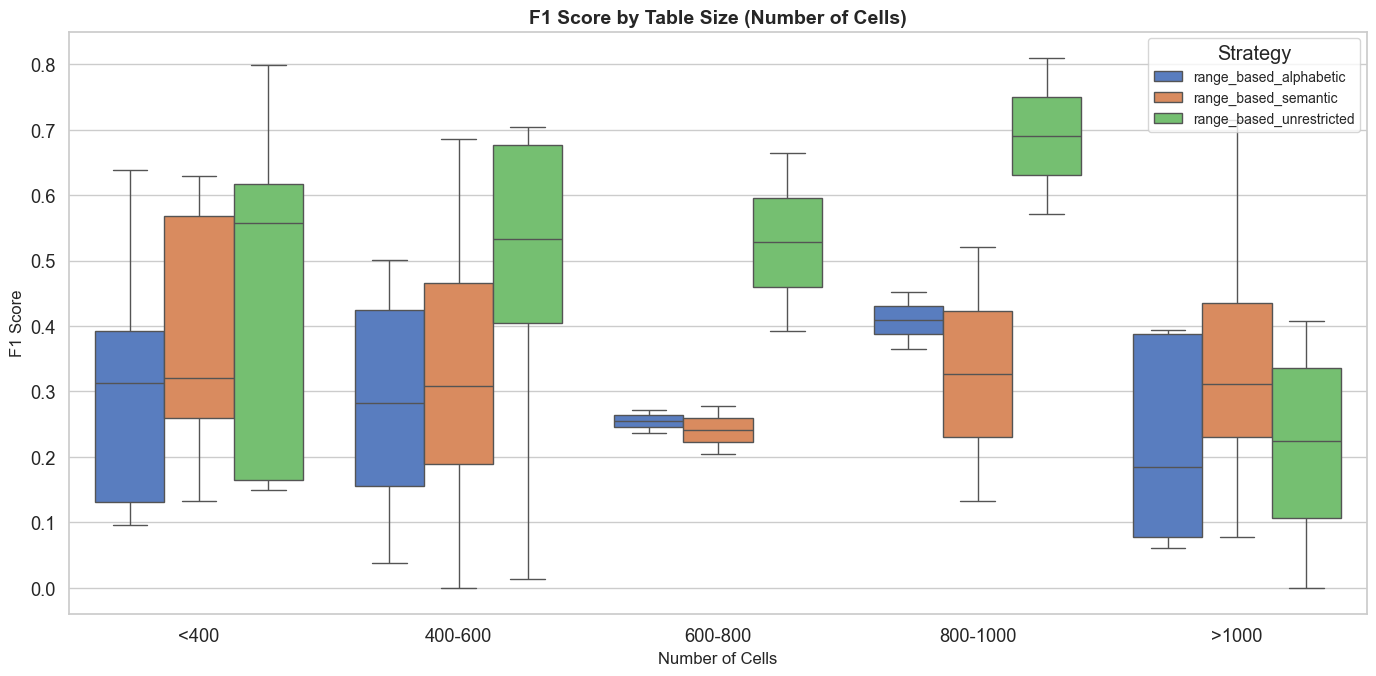

In [116]:
# F1 Score by Table Size (Number of Cells)
# Bin tables by cell count
df_results['cell_bin'] = pd.cut(df_results['num_cells'], 
                                 bins=[0, 400, 600, 800, 1000, float('inf')],
                                 labels=['<400', '400-600', '600-800', '800-1000', '>1000'])

plt.figure(figsize=(14, 7))
sns.boxplot(data=df_results, x='cell_bin', y='f1_score', hue='strategy')
plt.title('F1 Score by Table Size (Number of Cells)', fontsize=14, fontweight='bold')
plt.xlabel('Number of Cells', fontsize=12)
plt.ylabel('F1 Score', fontsize=12)
plt.legend(title='Strategy', loc='upper right', fontsize=10)
plt.tight_layout()
plt.savefig(output_dir / 'f1_by_table_size.png', dpi=300, bbox_inches='tight')
plt.show()

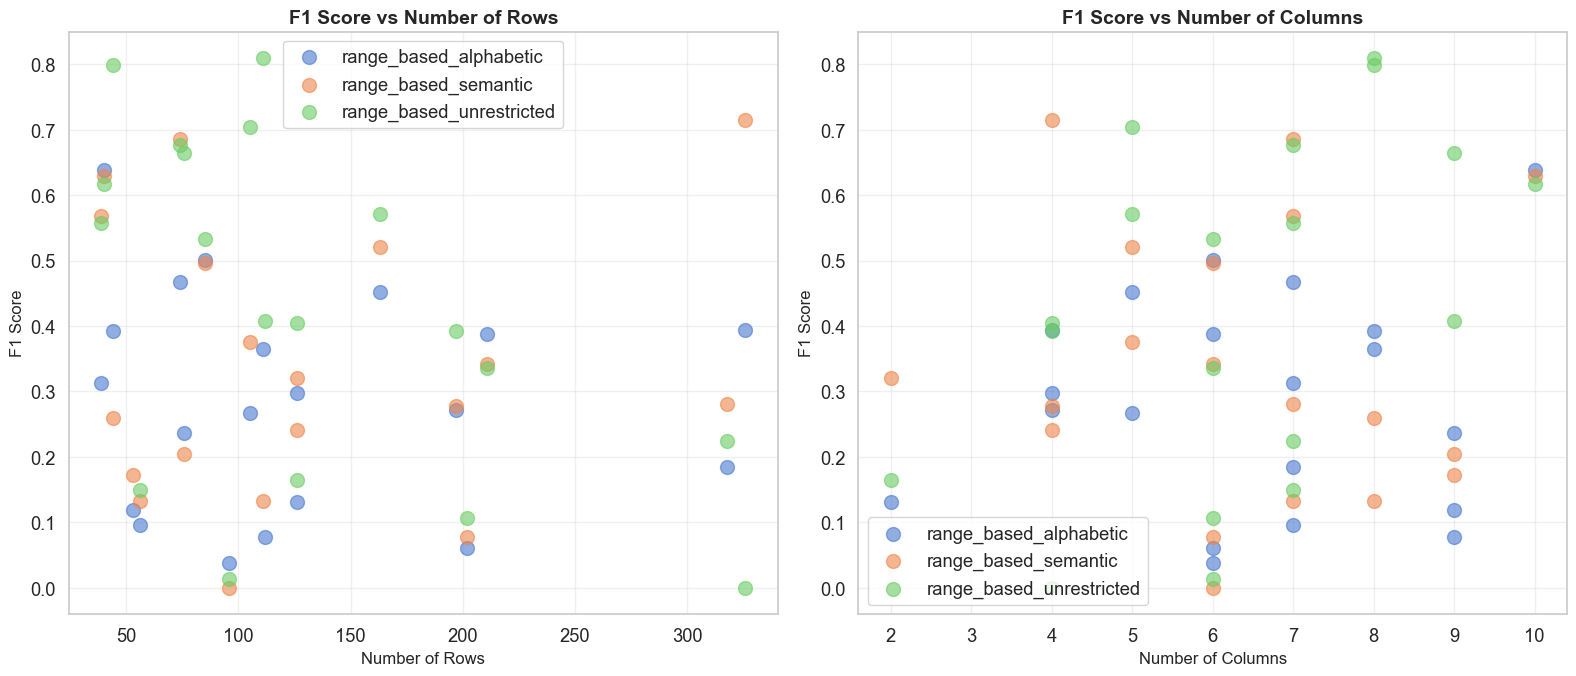

In [117]:
# F1 Score vs Number of Rows and Columns
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# F1 vs Number of Rows
for strategy in df_results['strategy'].unique():
    strategy_data = df_results[df_results['strategy'] == strategy]
    axes[0].scatter(strategy_data['num_rows'], strategy_data['f1_score'], 
                   label=strategy, alpha=0.6, s=100)

axes[0].set_title('F1 Score vs Number of Rows', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Number of Rows', fontsize=12)
axes[0].set_ylabel('F1 Score', fontsize=12)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# F1 vs Number of Columns
for strategy in df_results['strategy'].unique():
    strategy_data = df_results[df_results['strategy'] == strategy]
    axes[1].scatter(strategy_data['num_cols'], strategy_data['f1_score'], 
                   label=strategy, alpha=0.6, s=100)

axes[1].set_title('F1 Score vs Number of Columns', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Number of Columns', fontsize=12)
axes[1].set_ylabel('F1 Score', fontsize=12)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(output_dir / 'f1_by_dimensions.png', dpi=300, bbox_inches='tight')
plt.show()

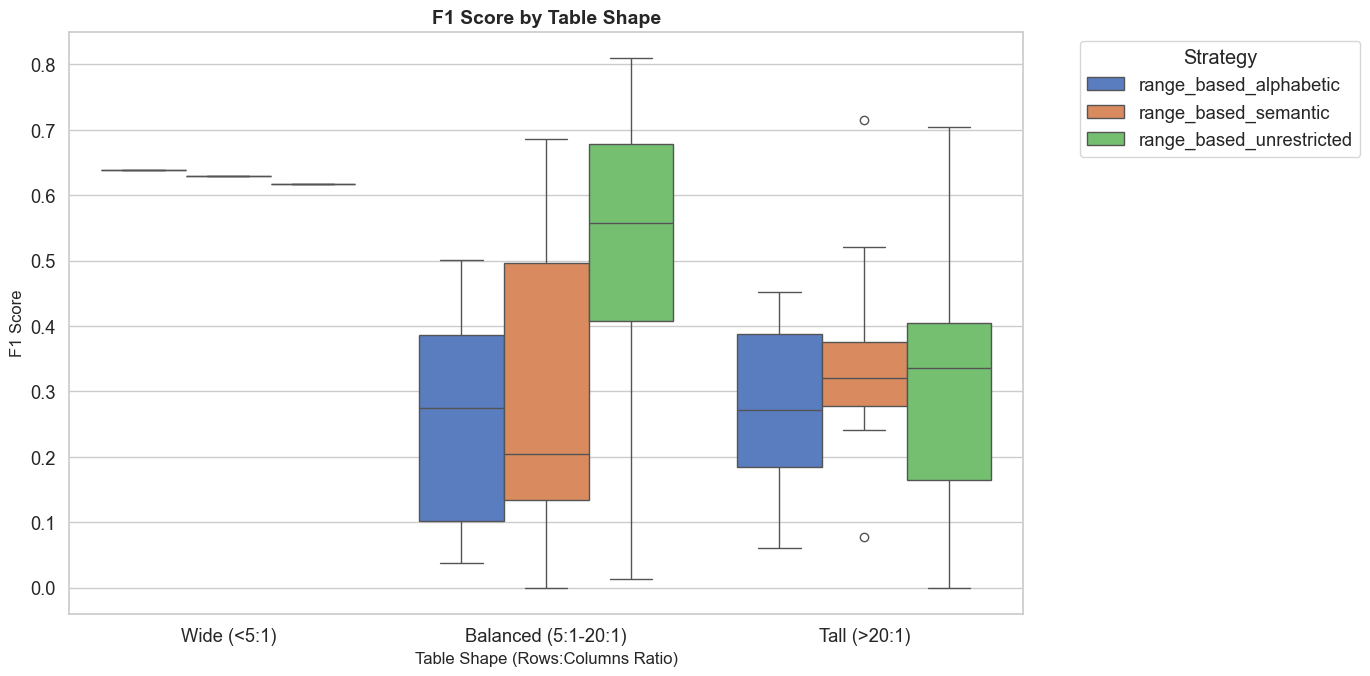

In [118]:
# Table Shape Analysis: Performance on Tall vs Wide Tables
df_results['aspect_ratio'] = df_results['num_rows'] / df_results['num_cols']
df_results['table_shape'] = pd.cut(df_results['aspect_ratio'], 
                                    bins=[0, 5, 20, float('inf')],
                                    labels=['Wide (<5:1)', 'Balanced (5:1-20:1)', 'Tall (>20:1)'])

plt.figure(figsize=(14, 7))
sns.boxplot(data=df_results, x='table_shape', y='f1_score', hue='strategy')
plt.title('F1 Score by Table Shape', fontsize=14, fontweight='bold')
plt.xlabel('Table Shape (Rows:Columns Ratio)', fontsize=12)
plt.ylabel('F1 Score', fontsize=12)
plt.legend(title='Strategy', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig(output_dir / 'f1_by_table_shape.png', dpi=300, bbox_inches='tight')
plt.show()

## Final Summary Report

In [119]:
# Generate comprehensive summary report
print("="*70)
print("COMPREHENSIVE EVALUATION SUMMARY")
print("="*70)
print(f"\nDataset: {len(df_results['table_id'].unique())} tables")
print(f"Strategies: {len(df_results['strategy'].unique())}")
print(f"Total evaluations: {len(df_results)}")

print("\n" + "="*70)
print("OVERALL PERFORMANCE BY STRATEGY")
print("="*70)

for strategy in df_results['strategy'].unique():
    strategy_data = df_results[df_results['strategy'] == strategy]
    
    print(f"\n{strategy.upper()}:")
    print(f"  F1 Score:        {strategy_data['f1_score'].mean():.4f} ± {strategy_data['f1_score'].std():.4f}")
    print(f"  Keys F1:         {strategy_data['keys_f1'].mean():.4f} ± {strategy_data['keys_f1'].std():.4f}")
    print(f"  Non-Keys F1:     {strategy_data['non_keys_f1'].mean():.4f} ± {strategy_data['non_keys_f1'].std():.4f}")
    print(f"  Avg Tokens:      {strategy_data['total_tokens'].mean():.0f}")
    print(f"  Avg Latency:     {strategy_data['total_latency'].mean():.2f}s")
    print(f"  Tokens/Row:      {strategy_data['tokens_per_row'].mean():.2f}")
    print(f"  Latency/Row:     {strategy_data['latency_per_row'].mean():.3f}s")
    print(f"  Avg Pages:       {strategy_data['total_pages'].mean():.1f}")
    print(f"  Duplicate Rate:  {strategy_data['duplicate_rows'].mean():.2f}")
    print(f"  Error Rate:      {strategy_data['error_rate'].mean():.4f}")

print("\n" + "="*70)
print("BEST PERFORMING STRATEGIES")
print("="*70)

best_f1 = df_results.groupby('strategy')['f1_score'].mean().idxmax()
best_efficiency = df_results.groupby('strategy')['tokens_per_row'].mean().idxmin()
best_speed = df_results.groupby('strategy')['latency_per_row'].mean().idxmin()

print(f"\nHighest F1 Score:     {best_f1}")
print(f"Most Token Efficient: {best_efficiency}")
print(f"Fastest:              {best_speed}")

print("\n" + "="*70)
print(f"All results saved to: {output_dir}")
print("="*70)

COMPREHENSIVE EVALUATION SUMMARY

Dataset: 20 tables
Strategies: 3
Total evaluations: 58

OVERALL PERFORMANCE BY STRATEGY

RANGE_BASED_ALPHABETIC:
  F1 Score:        0.2847 ± 0.1667
  Keys F1:         0.4871 ± 0.2258
  Non-Keys F1:     0.2407 ± 0.1762
  Avg Tokens:      5873
  Avg Latency:     39.58s
  Tokens/Row:      77.39
  Latency/Row:     0.530s
  Avg Pages:       4.0
  Duplicate Rate:  37.60
  Error Rate:      0.0000

RANGE_BASED_SEMANTIC:
  F1 Score:        0.3385 ± 0.2101
  Keys F1:         0.5565 ± 0.2895
  Non-Keys F1:     0.2913 ± 0.2301
  Avg Tokens:      6438
  Avg Latency:     52.39s
  Tokens/Row:      81.15
  Latency/Row:     0.599s
  Avg Pages:       7.0
  Duplicate Rate:  23.37
  Error Rate:      0.0000

RANGE_BASED_UNRESTRICTED:
  F1 Score:        0.4282 ± 0.2602
  Keys F1:         0.6599 ± 0.3513
  Non-Keys F1:     0.3751 ± 0.2670
  Avg Tokens:      9898
  Avg Latency:     70.98s
  Tokens/Row:      86.36
  Latency/Row:     0.679s
  Avg Pages:       11.5
  Duplicate R

In [120]:
# Save final summary statistics
final_summary = {
    'timestamp': timestamp,
    'num_tables': len(df_results['table_id'].unique()),
    'num_strategies': len(df_results['strategy'].unique()),
    'total_evaluations': len(df_results),
    'strategy_performance': {},
    'best_strategies': {
        'highest_f1': best_f1,
        'most_efficient': best_efficiency,
        'fastest': best_speed
    }
}

for strategy in df_results['strategy'].unique():
    strategy_data = df_results[df_results['strategy'] == strategy]
    final_summary['strategy_performance'][strategy] = {
        'f1_score_mean': float(strategy_data['f1_score'].mean()),
        'f1_score_std': float(strategy_data['f1_score'].std()),
        'keys_f1_mean': float(strategy_data['keys_f1'].mean()),
        'non_keys_f1_mean': float(strategy_data['non_keys_f1'].mean()),
        'avg_tokens': float(strategy_data['total_tokens'].mean()),
        'avg_latency': float(strategy_data['total_latency'].mean()),
        'tokens_per_row': float(strategy_data['tokens_per_row'].mean()),
        'latency_per_row': float(strategy_data['latency_per_row'].mean())
    }

summary_json_file = output_dir / 'final_summary.json'
with open(summary_json_file, 'w', encoding='utf-8') as f:
    json.dump(final_summary, f, indent=2)

print(f'Saved final summary to {summary_json_file}')

Saved final summary to processing/3_metrics/20251016_011011/final_summary.json
